# From Catalog to Analysis - Xarray basics

Explore the catalog and copy/paste whatever dataset you are interested in! If you want to follow along with me, use the "Sea-surface altimetry data from The Copernicus Marine Environment"

In [21]:
import xarray as xr

store = 'https://ncsa.osn.xsede.org/Pangeo/pangeo-cmems-duacs'
ds = xr.open_dataset(store, engine='zarr', chunks={})

In [20]:
ds

<xarray.Dataset> Size: 517GB
Dimensions:    (time: 8901, latitude: 720, longitude: 1440, nv: 2)
Coordinates:
    crs        int32 4B ...
    lat_bnds   (time, latitude, nv) float32 51MB dask.array<chunksize=(5, 720, 2), meta=np.ndarray>
  * latitude   (latitude) float32 3kB -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
    lon_bnds   (longitude, nv) float32 12kB dask.array<chunksize=(1440, 2), meta=np.ndarray>
  * longitude  (longitude) float32 6kB 0.125 0.375 0.625 ... 359.4 359.6 359.9
  * nv         (nv) int32 8B 0 1
  * time       (time) datetime64[ns] 71kB 1993-01-01 1993-01-02 ... 2017-05-15
Data variables:
    adt        (time, latitude, longitude) float64 74GB dask.array<chunksize=(5, 720, 1440), meta=np.ndarray>
    err        (time, latitude, longitude) float64 74GB dask.array<chunksize=(5, 720, 1440), meta=np.ndarray>
    sla        (time, latitude, longitude) float64 74GB dask.array<chunksize=(5, 720, 1440), meta=np.ndarray>
    ugos       (time, latitude, longitude) float64 74GB dask.array<chunksize=(5, 720, 1440), meta=np.ndarray>
    ugosa      (time, latitude, longitude) float64 74GB dask.array<chunksize=(5, 720, 1440), meta=np.ndarray>
    vgos       (time, latitude, longitude) float64 74GB dask.array<chunksize=(5, 720, 1440), meta=np.ndarray>
    vgosa      (time, latitude, longitude) float64 74GB dask.array<chunksize=(5, 720, 1440), meta=np.ndarray>
Attributes: (12/43)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-4 sea su...
    time_coverage_duration:          P1D
    time_coverage_end:               1993-01-01T12:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             1992-12-31T12:00:00Z
    title:                           DT merged all satellites Global Ocean Gr...

## The first plot is just seconds away

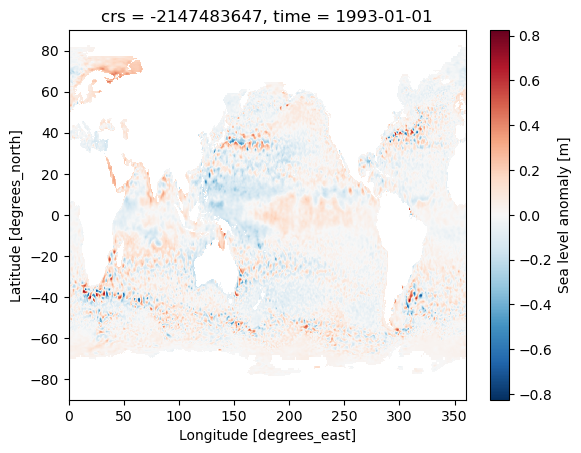

In [12]:
ds.sla.isel(time=0).plot()

In [13]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.feature import STATES

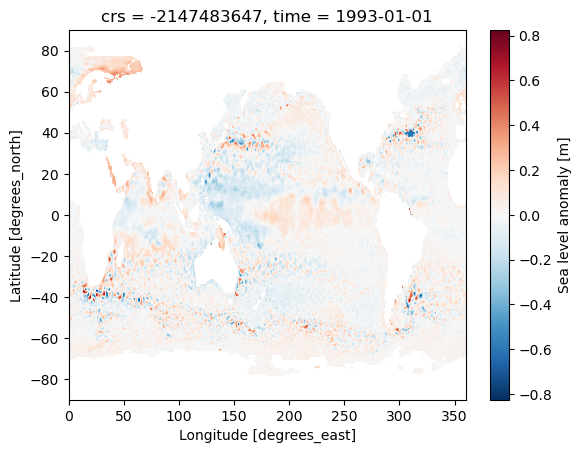

In [14]:
point_lon, point_lat = (310, 40)
ds.sla.isel(time=0).plot()
plt.plot(point_lon, point_lat, marker='*')

## Get a timeseries at our point

In [26]:
from dask.diagnostics import ProgressBar
ds_short = ds.isel(time=slice(0, 400))
with ProgressBar():
    timeseries = ds_short.sel(longitude=point_lon, latitude=point_lat, method='nearest').load()
timeseries

[########################################] | 100% Completed | 46.80 ss


<xarray.Dataset> Size: 29kB
Dimensions:    (time: 400, nv: 2)
Coordinates:
    crs        int32 4B -2147483647
    lat_bnds   (time, nv) float32 3kB 40.0 40.25 40.0 40.25 ... 40.25 40.0 40.25
    latitude   float32 4B 40.12
    lon_bnds   (nv) float32 8B 310.0 310.2
    longitude  float32 4B 310.1
  * nv         (nv) int32 8B 0 1
  * time       (time) datetime64[ns] 3kB 1993-01-01 1993-01-02 ... 1994-02-04
Data variables:
    adt        (time) float64 3kB 0.4353 0.4061 0.3663 ... 0.0047 0.0273 0.0494
    err        (time) float64 3kB 0.0906 0.091 0.0918 ... 0.1644 0.1645 0.1646
    sla        (time) float64 3kB 0.2004 0.1712 0.1313 ... -0.2076 -0.1855
    ugos       (time) float64 3kB 0.596 0.6655 0.7231 ... 0.1912 0.227 0.2622
    ugosa      (time) float64 3kB 0.4217 0.4911 0.5487 ... 0.0168 0.0527 0.0878
    vgos       (time) float64 3kB 0.6785 0.7168 0.7232 ... 0.5165 0.5397 0.5531
    vgosa      (time) float64 3kB 0.7601 0.7984 0.8048 ... 0.5981 0.6213 0.6347
Attributes: (12/43)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-4 sea su...
    time_coverage_duration:          P1D
    time_coverage_end:               1993-01-01T12:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             1992-12-31T12:00:00Z
    title:                           DT merged all satellites Global Ocean Gr...

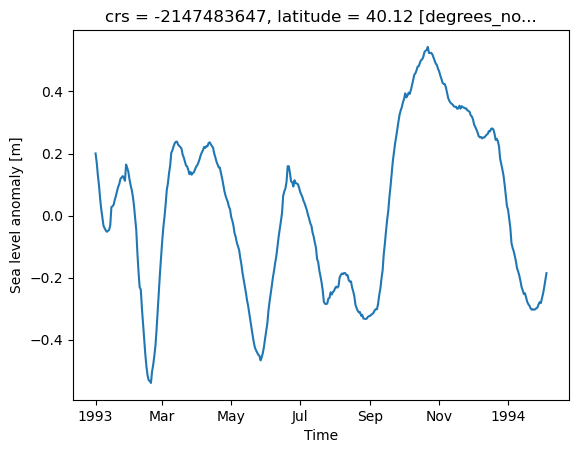

In [27]:
timeseries.sla.plot()

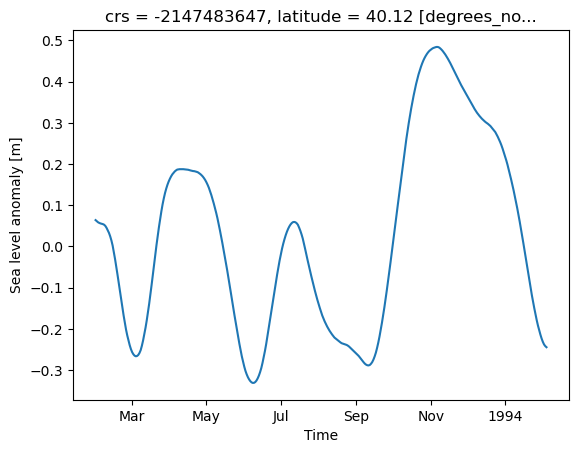

In [29]:
timeseries.sla.rolling(time=30).mean().plot()

## Calculate standard devition over time

In [31]:
with ProgressBar():
    stdv = ds_short.sla.std('time').load()
stdv

[########################################] | 100% Completed | 9.87 ss


<xarray.DataArray 'sla' (latitude: 720, longitude: 1440)> Size: 8MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    crs        int32 4B -2147483647
  * latitude   (latitude) float32 3kB -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * longitude  (longitude) float32 6kB 0.125 0.375 0.625 ... 359.4 359.6 359.9